In [1]:
import qutip as qt
import numpy as np
import tqdm
import time
import warnings
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec
import sys
import yaml

## Imports and program configuration

In [2]:
def load_config(config_path):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def generate_error_list(config, error_type=None):
    """Generate error list using np.linspace with bounds from config"""
    if error_type is None:
        error_type = config['errors']['error_type']
    
    error_range_map = {
        'j': config['errors']['j_error_range'],
        'l': config['errors']['l_error_range'],
        'z': config['errors']['z_error_range']
    }
    
    error_range = error_range_map.get(error_type)
    if error_range is None:
        raise ValueError(f"Invalid error type: {error_type}")
    
    return np.linspace(
        error_range['lower'],
        error_range['upper'], 
        error_range['num_points']
    )

def get_data_filename(config, error_list):
    """Generate consistent filename for saving and loading data"""
    N = config['system']['N']
    error_type = config['errors']['error_type']
    Nshots = config['simulation']['Nshots']
    num_points = len(error_list)
    
    output_dir = config['experiment']['output_dir']
    return f"{output_dir}/errors/{error_type}_err_N{N}_{num_points}_points_{Nshots}_shots"


## Dynamics

In [3]:
def select_error(err, error_type):
    if error_type == "j":
        return err, 0, 0
    elif error_type == "l":
        return 0, err, 0
    elif error_type == "z":
        return 0, 0, err
    else:
        raise ValueError(f"{error_type} is not a valid type of error, only 'j', 'l', and 'z' allowed")

def error_loop(N, lmd, J, ti, tf, Nsteps, Nshots, error_list, error_type, register_size=None):
    fidelity_means = np.array([])
    fidelity_errors = np.array([])
    
    for err in tqdm.tqdm(error_list, desc="Error sweep"):
        fidelities = []
        for _ in range(Nshots):
            j_err, l_err, z_err = select_error(err, error_type)

            H_t = Ham.Hamiltonian(
                system_size=N,
                mode="transport",
                lambda_factor=lmd,
                global_J=J,
                j_error=j_err,
                l_error=l_err, 
                z_error=z_err
            )
            
            fidelities.append(dyn.LightweightAlgorithm(initial_system, final_system, ti, tf, Nsteps, H_t))
        
        fmean, ferror = calculate_result_statistics(fidelities)
        fidelity_means = np.append(fidelity_means, fmean)
        fidelity_errors = np.append(fidelity_errors, ferror)

    return fidelity_means, fidelity_errors

def calculate_result_statistics(fidelity):
    fidelity_mean = np.mean(fidelity)
    fidelity_error = np.std(fidelity, ddof=1) / np.sqrt(len(fidelity))
    return fidelity_mean, fidelity_error

## Simulation

In [4]:
def run_simulation(config):
    """Run the full simulation with parameters from config"""
    print("Starting simulation...")
    
    # Extract parameters from config
    N = config['system']['N']
    lmd = config['system']['lambda'] 
    J = config['system']['J']
    state_dict = config['system']['state_dictionary']
    
    ti = config['simulation']['ti']
    tf = np.pi/lmd
    Nsteps = config['simulation']['Nsteps']
    Nshots = config['simulation']['Nshots']
    
    error_type = config['errors']['error_type']
    error_list = generate_error_list(config, error_type)
    
    # Initialize system
    global initial_system, final_system
    initial_system, final_system, register_size = md.initialize_system(state_dict, N, one_step = True)
    
    # Run simulation
    print(f"Running {Nshots} shots for {len(error_list)} error values...")
    fidelities, fidelity_errors = error_loop(N, lmd, J, ti, tf, Nsteps, Nshots, error_list, error_type, register_size)
    
    # Save results
    data_filename = get_data_filename(config, error_list)
    dh.save_three_arrays(error_list, fidelities, fidelity_errors, data_filename,
                        description=f'{error_type.upper()} errors vs fidelity for {config["experiment"]["name"]}')
    
    print(f"Simulation completed! Results saved to: {data_filename}")
    return error_list, fidelities, fidelity_errors

## Plotting

In [5]:
def load_and_plot(config):
    """Load existing data and generate plots"""
    print("Loading existing data for plotting...")
    
    error_type = config['errors']['error_type']
    error_list = generate_error_list(config, error_type)
    data_filename = get_data_filename(config, error_list)
    
    try:
        loaded_x, loaded_means, loaded_errors = dh.fetch_three_arrays(data_filename)
        
        if config['plotting']['save_figures']:
            output_dir = config['experiment']['output_dir']
            plots.plot_fidelity_vs_error(
                loaded_x, loaded_means, loaded_errors,
                title=config['plotting']['title'],
                xlabel=config['plotting']['xlabel'],
                save_figure=True,
                save_path=f"{output_dir}/figures/errors",
                file_tag=f"{error_type}_err_N{config['system']['N']}_{len(error_list)}_points_{config['simulation']['Nshots']}_shots"
            )
            print(f"Plot generated and saved!")
        else:
            print("Plotting disabled in config (save_figures: false)")
            
    except FileNotFoundError:
        print(f"Error: Data file {data_filename} not found. Please run simulation first.")
    except Exception as e:
        print(f"Error loading data: {e}")

## Main program

In [6]:
def main(config):
    # Load configuration
    exp_name = config['experiment']['name']
    
    print(f"Experiment: {exp_name}")
    print(f"Description: {config['experiment']['description']}")
    print(f"Run simulation: {config['experiment']['run_simulation']}")
    
    # Check if we should run simulation or just plot
    if config['experiment']['run_simulation']:
        # Run simulation and then plot
        error_list, fidelities, fidelity_errors = run_simulation(config)
        
        # Plot the newly generated data
        if config['plotting']['save_figures']:
            output_dir = config['experiment']['output_dir']
            plots.plot_fidelity_vs_error(
                error_list, fidelities, fidelity_errors,
                title=config['plotting']['title'],
                xlabel=config['plotting']['xlabel'],
                save_figure=True,
                save_path=f"{output_dir}/figures/",
                file_tag=f"{config['errors']['error_type']}_err_N{config['system']['N']}_{len(error_list)}_points_{config['simulation']['Nshots']}_shots"
            )
    else:
        # Only plot existing data
        load_and_plot(config)

## Run

In [8]:
if __name__ == "__main__":
    # You can pass config file as command line argument or use default
    config_file = "../config/error_config_radagast.yaml"

    config = load_config(config_file)
    import_path = config['sources']


    sys.path.append(f'{import_path}')
    import model_building as md
    import Hamiltonian as Ham
    import dynamics as dyn
    import data_handling as dh
    import plots as plots

    
    main(config)

Experiment: error_analysis_j
Description: J error analysis for N=8 system
Run simulation: True
Starting simulation...
Running 5 shots for 10 error values...


Error sweep: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


FileExistsError: File '../../error_files/errors/l_err_N8_10_points_5_shots.npz' already exists. Operation aborted to prevent overwriting.

Experiment: error_analysis_j
Description: J error analysis for N=8 system
Run simulation: False
Loading existing data for plotting...
Successfully loaded three arrays from: ../../error_files/errors/l_err_N8_10_points_5_shots.npz
Array shapes: (10,), (10,), (10,)


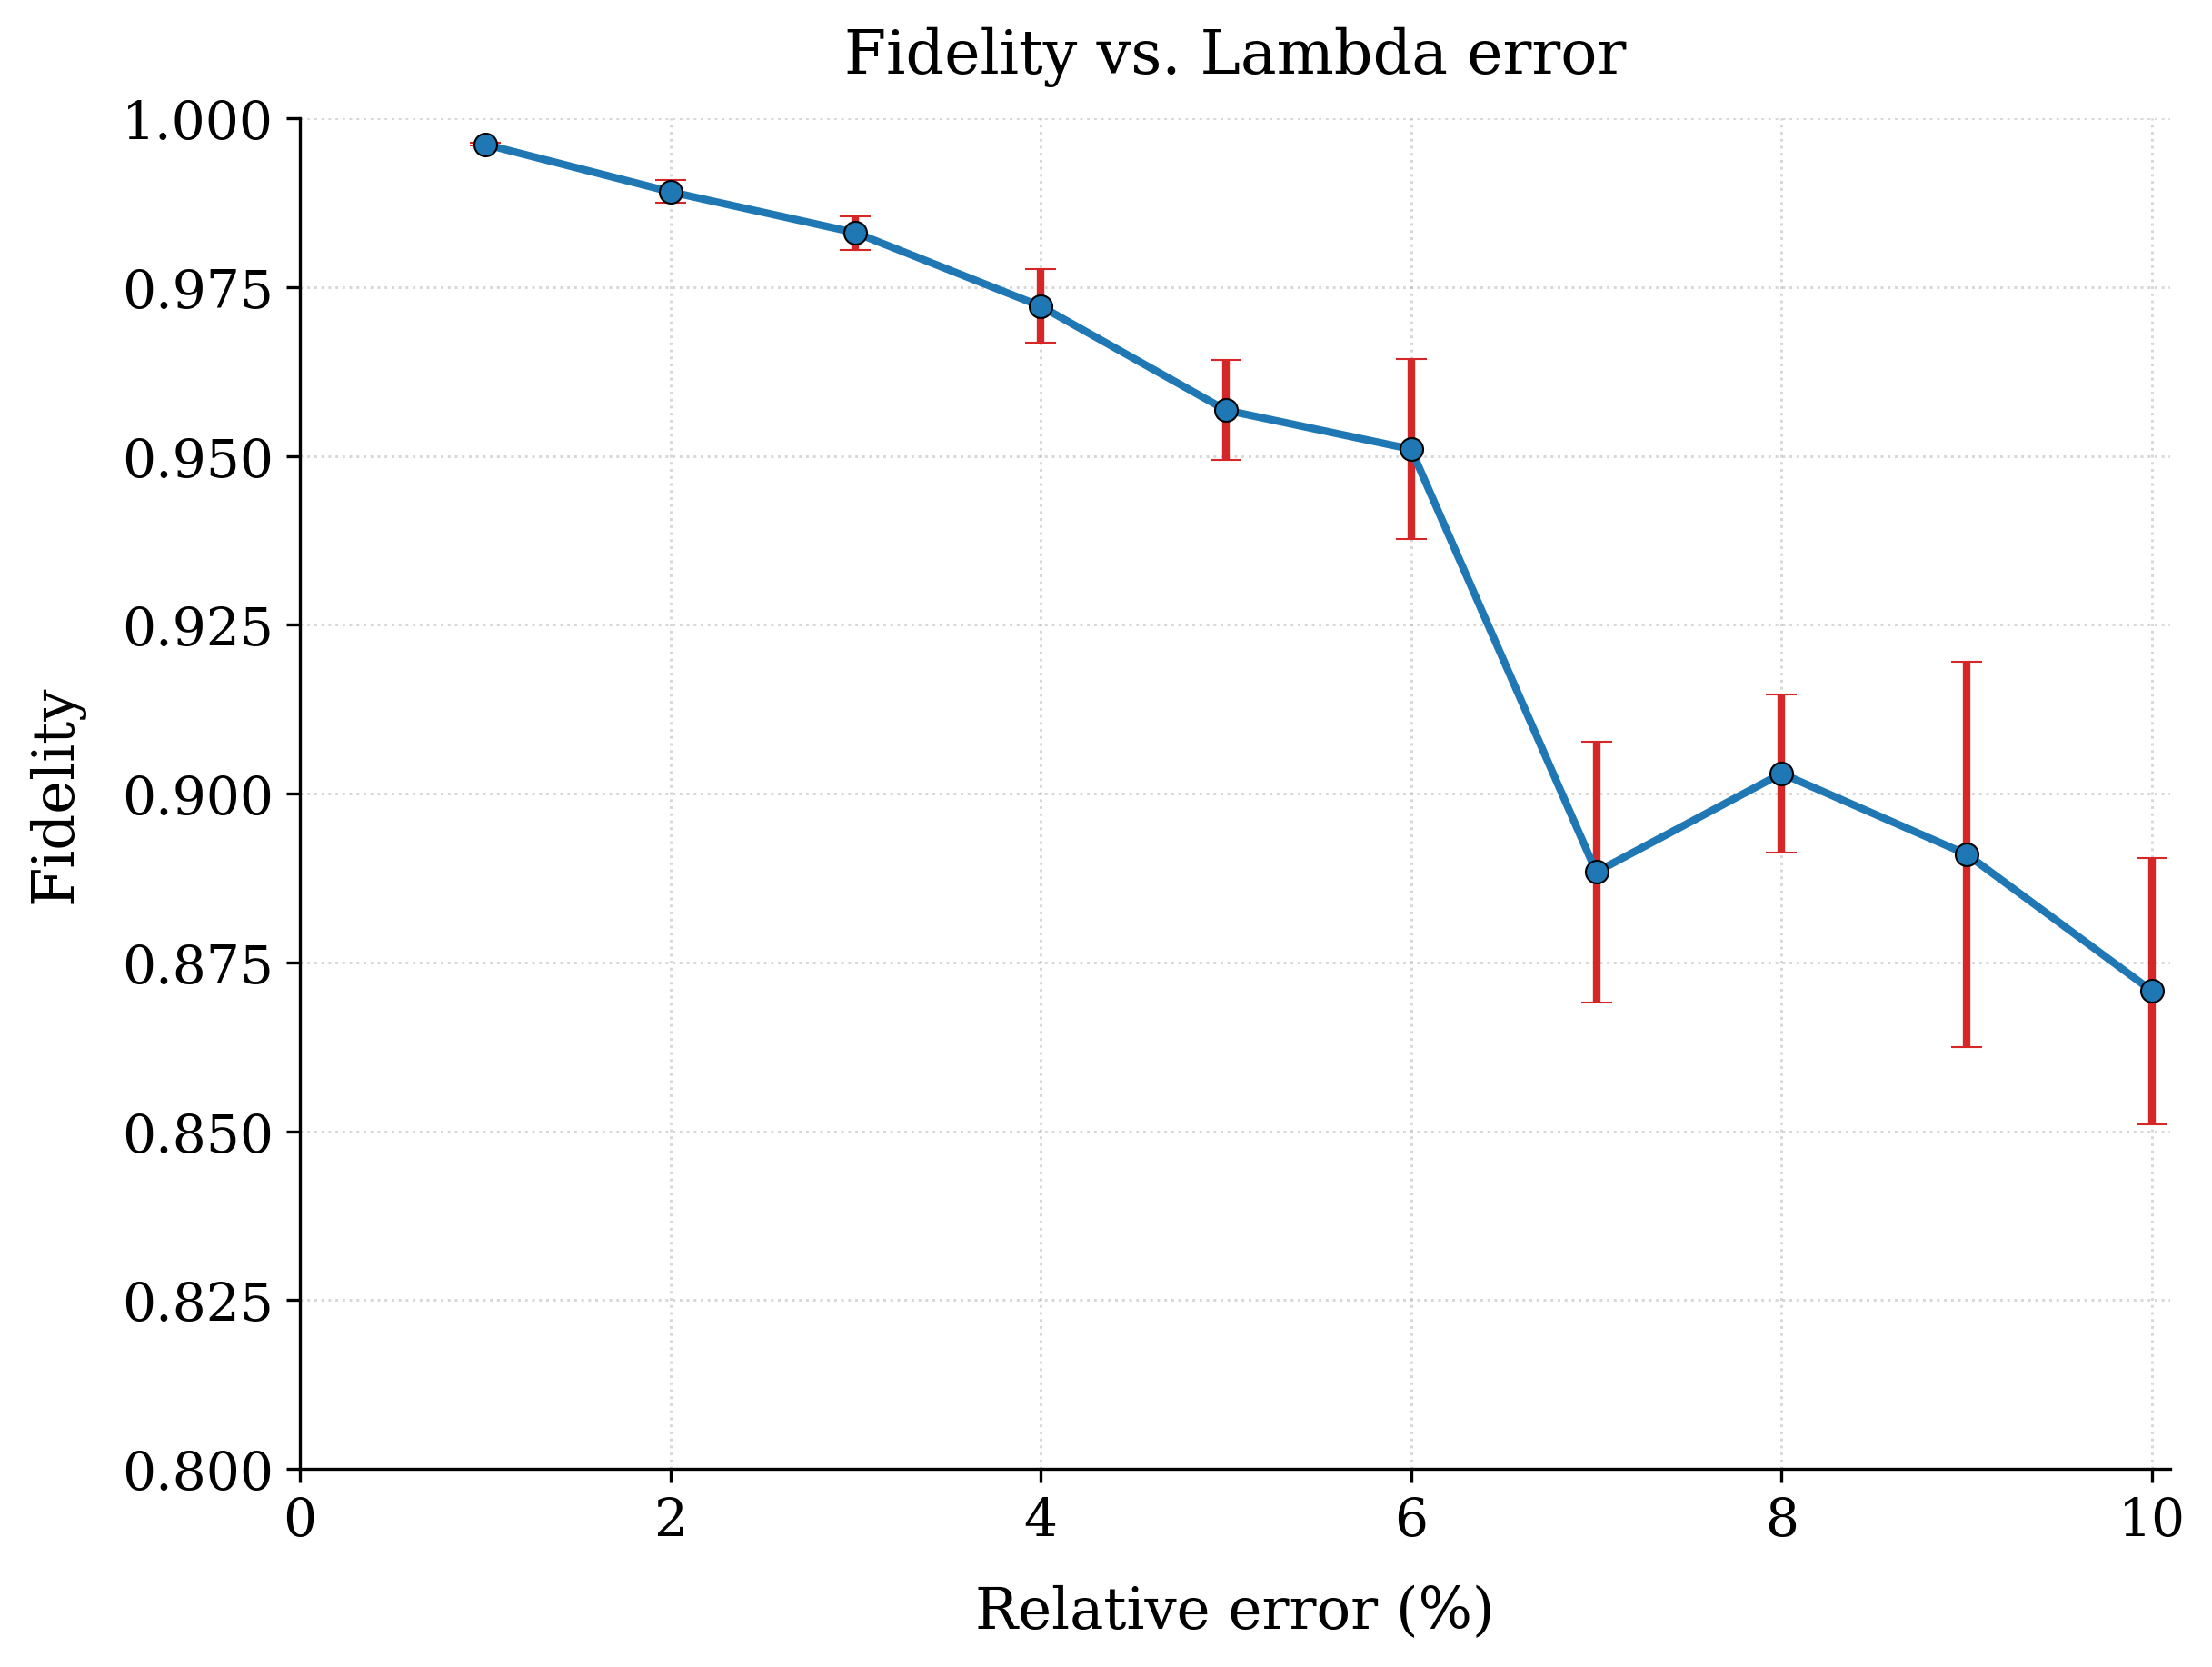

Plot generated and saved!


In [ ]:


main(config)